In [39]:
import sys, os
sys.path.append(os.path.expanduser('~/source'))
#
import numpy as np
import importlib, os, hashlib, json, copy, time
from quick_sim import setup_sim
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from sus.library.potentials import coupled_flux_qubit_pot, coupled_flux_qubit_force
import kyle_tools as kt
import matplotlib.pyplot as plt
# from PARAMETER_INPUT import *
# from PARAMETER_INPUT import _lambda, _theta, _eta
import edward_tools.visualization as visualization
import matplotlib.animation as animation

In [40]:
PHI_0 = 2.067833848 * 1e-15
k_B = 1.38e-23
T = 0.5
k_BT = k_B * T

In [41]:
I_p_1, I_p_2 = 2e-6 , 2e-6  # Amp
I_m_1, I_m_2 = 7e-9, 1e-9                                # Amp
R_1, R_2 = 371, 371                                # ohm
C_1, C_2 = 4e-9, 4e-9                              # F
L_1, L_2 = 1e-9, 1e-9                              # H

quick_doubler = lambda x1, x2: np.hstack([np.array([x1] * 2), np.array([x2]*2)])
I_p, I_m = quick_doubler(I_p_1, I_p_2), quick_doubler(I_m_1, I_m_2)

m_c = C_1
m_1 = C_1
m_2 = C_2
x_c = PHI_0 / (2 * np.pi)
time_scale_factor = 1
t_c = np.sqrt(L_1 * C_1)


U0_1 = m_c * x_c**2 / t_c
U0_2 = m_2 * x_c**2 / t_c
kappa_1, kappa_2, kappa_3, kappa_4 = k_BT/U0_1, k_BT/U0_1, k_BT/U0_1, k_BT/U0_1


lambda_1 = 2 * np.sqrt(L_1 * C_1) / (C_1 * R_1)
theta_1  = 1
eta_1    = (L_1 * C_1 / R_1**2)**0.25 * np.sqrt(2 * kappa_1)

lambda_2 = 2 * np.sqrt(L_1 * C_1) / (C_2 * R_2)
theta_2  = 1 / (C_2/C_1)
eta_2    = (L_1 * C_1 / R_1**2)**0.25 * np.sqrt(2 * kappa_2 * (R_1 * C_1) / (R_2 * C_2))

lambda_3 = 2 * np.sqrt(L_1 * C_1) / (C_1 * R_1)
theta_3  = 4
eta_3    = (L_1 * C_1 / R_1**2)**0.25 * np.sqrt(2 * kappa_3)

lambda_4 = 2 * np.sqrt(L_1 * C_1) / (C_2 * R_2)
theta_4  = 4 / (C_2/C_1)
eta_4    = (L_1 * C_1 / R_1**2)**0.25 * np.sqrt(2 * kappa_4 * (R_1 * C_1) / (R_2 * C_2))

gamma = 20


beta_1 = 2 * np.pi * L_1 * I_p_1 / PHI_0; 
beta_2 = 2 * np.pi * L_2 * I_p_2 / PHI_0;

d_beta_1 = 2 * np.pi * L_1 * I_m_1 / PHI_0; 
d_beta_2 = 2 * np.pi * L_2 * I_m_2 / PHI_0;

In [42]:
_lambda = np.array([lambda_1, lambda_2, lambda_3, lambda_4])
_theta  = np.array([theta_1, theta_2, theta_3, theta_4])
_eta  =   np.array([eta_1, eta_2, eta_3, eta_4])

In [43]:
phi_1x_off, phi_2x_off = 0, 0
phi_1dcx_off, phi_2dcx_off, M_12_off = 0, 0, 0
phi_1dcx_on, phi_2dcx_on, M_12_on = 3.0, 3.0, -0.7

potential_params = {
        "U0_1": U0_1, "U0_2": U0_2, "g_1": gamma, "g_2": gamma, 
        "beta_1": beta_1, "beta_2": beta_2, "delta_beta_1": d_beta_1, "delta_beta_2": d_beta_2,
        "phi_1x": phi_1x_off, "phi_2x": phi_2x_off, "phi_1dcx": phi_1dcx_off, "phi_2dcx": phi_2dcx_off,
        "M_12": M_12_off, "x_c": x_c
    }

potential_params = [U0_1, U0_2, gamma, gamma, beta_1, beta_2, d_beta_1, d_beta_2, phi_1x_off, phi_2x_off,
                    phi_1dcx_off, phi_2dcx_off, M_12_off, x_c]

In [44]:
# the potential to input into the system
cfq_pot = Potential(coupled_flux_qubit_pot, coupled_flux_qubit_force, 14, 4, default_params = potential_params, 
         relevant_domain = [[-5, -5, -5, -5], [5, 5, 5, 5]])

In [45]:
protocol_init_params = [U0_1, U0_2, gamma, gamma, beta_1, beta_2, d_beta_1, d_beta_2, phi_1x_off, phi_2x_off,
                    phi_1dcx_off, phi_2dcx_off, M_12_off, x_c]

# mix in y
protocol_step_1_parmas = [U0_1, U0_2, gamma, gamma, beta_1, beta_2, d_beta_1, d_beta_2, phi_1x_off, phi_2x_off,
                    phi_1dcx_off, phi_2dcx_on, M_12_off, x_c] 

# conditional tilt
protocol_step_2_parmas = [U0_1, U0_2, gamma, gamma, beta_1, beta_2, d_beta_1, d_beta_2, phi_1x_off, phi_2x_off,
                    phi_1dcx_off, phi_2dcx_on, M_12_on, x_c]

# raise the barrier
protocol_step_3_parmas = [U0_1, U0_2, gamma, gamma, beta_1, beta_2, d_beta_1, d_beta_2, phi_1x_off, phi_2x_off,
                    phi_1dcx_off, phi_2dcx_off, M_12_on, x_c]

# return to 4 Well potential
protocol_step_4_parmas = [U0_1, U0_2, gamma, gamma, beta_1, beta_2, d_beta_1, d_beta_2, phi_1x_off, phi_2x_off,
                    phi_1dcx_off, phi_2dcx_off, M_12_off, x_c]


eq_protocol = Protocol((0, 1), np.array([protocol_init_params, protocol_init_params]).T, interpolation="linear")



t_1 = 50; t_2 = 100; t_3 = 100; t_4 = 50;
t_2 = t_2 + t_1
t_3 = t_3 + t_2
t_4 = t_3 + t_4

comp_protocol_1 = Protocol((0, t_1), np.array([protocol_init_params, protocol_step_1_parmas]).T, 
                           interpolation="linear")
comp_protocol_2 = Protocol((t_1, t_2), np.array([protocol_step_1_parmas, protocol_step_2_parmas]).T, 
                           interpolation="linear")
comp_protocol_3 = Protocol((t_2, t_3), np.array([protocol_step_2_parmas, protocol_step_3_parmas]).T, 
                           interpolation="linear")
comp_protocol_4 = Protocol((t_3, t_4), np.array([protocol_step_3_parmas, protocol_step_4_parmas]).T, 
                           interpolation="linear")

comp_protocol = Compound_Protocol([comp_protocol_1, comp_protocol_2, comp_protocol_3, comp_protocol_4])

In [46]:
import cfqRunner 
import importlib
cfqRunner = importlib.reload(cfqRunner)

In [47]:
sim_params = {
        "U0_1": U0_1, "U0_2": U0_2, "g_1": gamma, "g_2": gamma, 
        "beta_1": beta_1, "beta_2": beta_2, "delta_beta_1": d_beta_1, "delta_beta_2": d_beta_2,
        "phi_1x": phi_1x_off, "phi_2x": phi_2x_off, "phi_1dcx": phi_1dcx_off, "phi_2dcx": phi_2dcx_off,
        "M_12": M_12_off, "x_c": x_c,
    
        'beta': 1, 'scale': 1, 'dt': 1/1_000, 'lambda': 1, 'N': 10_000, 'target_work': None,
        'sim_params': [_lambda, _theta, _eta]
    
    }

In [48]:
print(sim_params)

{'U0_1': 2.166214900397897e-31, 'U0_2': 2.166214900397897e-31, 'g_1': 20, 'g_2': 20, 'beta_1': 6.07706979287205, 'beta_2': 6.07706979287205, 'delta_beta_1': 0.021269744275052172, 'delta_beta_2': 0.0030385348964360255, 'phi_1x': 0, 'phi_2x': 0, 'phi_1dcx': 0, 'phi_2dcx': 0, 'M_12': 0, 'x_c': 3.291059784019349e-16, 'beta': 1, 'scale': 1, 'dt': 0.001, 'lambda': 1, 'N': 10000, 'target_work': None, 'sim_params': [array([0.00269542, 0.00269542, 0.00269542, 0.00269542]), array([1., 1., 4., 4.]), array([0.01853177, 0.01853177, 0.01853177, 0.01853177])]}


In [49]:
cfq_runner = cfqRunner.CFQRunner(potential=cfq_pot, params=sim_params, eq_protocol = eq_protocol, 
                                comp_protocol = comp_protocol)

In [50]:
cfq_runner.initialize_sim()

from SimRunner.py, set_sim_attributes


In [51]:
cfq_runner.set_sim_attributes()

using a lower resolution for searching a space in >3 dimensions
new resolution is 50
 found 10000 samples out of 10000
from system: finish the while loop in sampling.

The as_step is 600
The dt is 0.001
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 1. 4. 4.] and eta: [0.01853177 0.01853177 0.01853177 0.01853177]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 300.0
from simulation.py: number of steps: 300000, dt: 0.001


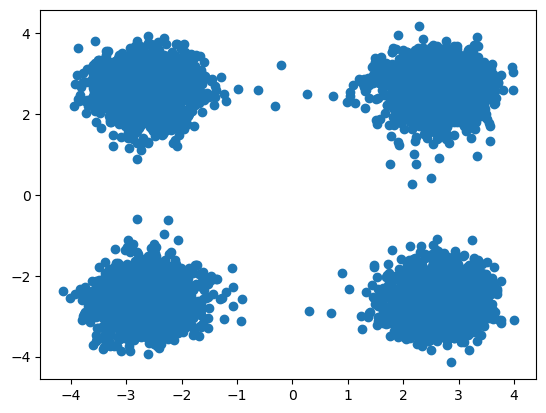

In [52]:
plt.scatter(cfq_runner.init_state[:, 0, 0], cfq_runner.init_state[:, 1, 0])

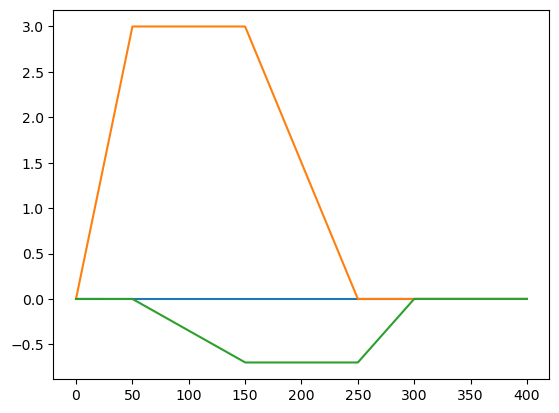

In [53]:
t_array = np.linspace(0, 400, 1000)
phi_1_dc_array = [cfq_runner.protocol.get_params(t)[10] for t in t_array]
phi_2_dc_array = [cfq_runner.protocol.get_params(t)[11] for t in t_array]
M_12_array = [cfq_runner.protocol.get_params(t)[12] for t in t_array]
# protocol_params_at_t = cfq_runner.protocol.get_params(t)
plt.plot(t_array, phi_1_dc_array)
plt.plot(t_array, phi_2_dc_array)
plt.plot(t_array, M_12_array)

In [ ]:
cfq_runner.run_sim()


 initializing...
from SimRunner.py, set_sim_attributes
using a lower resolution for searching a space in >3 dimensions
new resolution is 50
 found 10000 samples out of 10000
from system: finish the while loop in sampling.

The as_step is 600
The dt is 0.001
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 1. 4. 4.] and eta: [0.01853177 0.01853177 0.01853177 0.01853177]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 300.0
from simulation.py: number of steps: 300000, dt: 0.001

 running sim...


In [ ]:
cfq_runner.sim.work_dist_array

In [ ]:
work_distribution = cfq_runner.sim.work_dist_array
plt.hist(cfq_runner.sim.work_dist_array, bins = 50)

In [ ]:
mean_work = np.mean(work_distribution)
jarzy_term = np.mean(np.exp(-work_distribution))
print(f"mean work is {mean_work}, jarzyn term is {jarzy_term}")

1/100, mean work is 0.8883943705312658, jarzyn term is 0.6002266100965795


# animations

In [37]:
all_state = cfq_runner.sim.output.all_state['states']

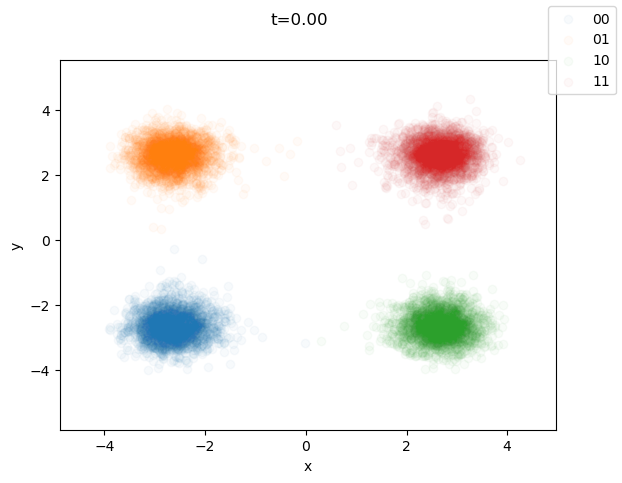

In [38]:
from IPython.display import HTML
from IPython import display
ani,_,_ = kt.animate_sim(all_state[:,:,(0, 1),0],
                         frame_skip=500, color_by_state=True)

video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)